In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import re

# Создаем датасет
def create_dataset():
    data = []
    
    for i in range(500):
        employee = {
            'ФИО сотрудника': f'Сотрудник {i+1}',
            'Профессиональные качества': sum(random.choices([0,1], k=5)),
            'Личные качества': sum(random.choices([0,1], k=4)),
            'Были ли встречи 1:1': random.choice([0,1]),
            'Дискоммуникация': random.choice([0,1]),
            'Желание развиваться': random.choice([1,0.5,0]),
            'Считаешь ли преемником': random.choice([0,1]),
            'Готовность преемника': random.choice(['1-2 года', '3 года', '3+ лет']),
            'Риск ухода': random.randint(0,10),
            'Приоритет 1': '',
            'Приоритет 2': '',
            'Подведение итогов': ' '.join(random.choices(
                ['недостаточная коммуникация', 'проблемы с дедлайнами', 'отсутствие инициативы', 
                 'трудности в командной работе', 'недостаток навыков', 'низкая мотивация', 
                 'конфликты с коллегами', 'успешное выполнение', 'превышение ожиданий'], 
                k=random.randint(2,5)
            ))
        }
        
        # Оценка руководителя
        employee.update({
            'Достижение результатов (рук)': random.randint(0,10),
            'Комментарий о личных качествах (рук)': ' '.join(random.choices(
                ['ответственный', 'инициативный', 'непунктуальный', 'коммуникабельный', 
                 'неорганизованный', 'командный игрок', 'недисциплинированный'], 
                k=random.randint(2,4)
            )),
            'Личный вклад': random.randint(0,10),
            'Качество взаимодействия (рук)': random.randint(0,10),
            'Рекомендации (рук)': ' '.join(random.choices(
                ['улучшить коммуникацию', 'соблюдать дедлайны', 'повысить инициативность', 
                 'работать в команде', 'развивать навыки'], 
                k=random.randint(1,3)
            )),
            'Общий рейтинг (рук)': random.randint(0,10),
            'Итоговая категория': random.choice(['высокий', 'средний', 'низкий']),
            'Общий балл (рук)': random.uniform(0,10)
        })
        
        # Оценка коллег
        employee.update({
            'ФИО коллеги': f'Коллега {random.randint(1,100)}',
            'Оцениваемая задача': random.choice(['проект А', 'проект Б', 'проект В']),
            'Достижение результатов (кол)': random.randint(0,10),
            'Комментарий о личных качествах (кол)': ' '.join(random.choices(
                ['ответственный', 'непунктуальный', 'коммуникабельный', 'неорганизованный'], 
                k=random.randint(2,3)
            )),
            'Качество взаимодействия (кол)': random.randint(0,10),
            'Рекомендации (кол)': ' '.join(random.choices(
                ['улучшить коммуникацию', 'соблюдать дедлайны', 'работать в команде'], 
                k=random.randint(1,2)
            )),
            'Балл за результаты (кол)': random.randint(0,10)
        })
        
        employee.update({
            'Наименование задачи': random.choice(['задача 1', 'задача 2', 'задача 3']),
            'Достигнутые результаты': ' '.join(random.choices(
                ['выполнено', 'не выполнено', 'частично выполнено'], 
                k=1
            )),
            'Личный вклад и метрики': random.randint(0,10),
            'Ссылка на рабочее пространство': f'link_{random.randint(1000,9999)}',
            'Приобретенные навыки': ' '.join(random.choices(
                ['новые навыки', 'улучшение существующих', 'нет навыков'], 
                k=random.randint(1,2)
            )),
            'План улучшений': ' '.join(random.choices(
                ['улучшить коммуникацию', 'соблюдать дедлайны', 'повысить инициативность'], 
                k=random.randint(1,2)
            )),
            'Оценка взаимодействия (сам)': random.randint(0,10),
            'Общая удовлетворенность (сам)': random.randint(0,10),
            'Общий балл (сам)': random.uniform(0,10)
        })
        
        employee.update({
            '№': i+1,
            'Цель': random.choice(['цель 1', 'цель 2', 'цель 3']),
            'Сроки': f'{random.randint(1,12)}/2025',
            'Ожидаемые результаты': random.choice(['результат 1', 'результат 2', 'результат 3']),
            'Ключевые задачи': random.choice(['задача А', 'задача Б', 'задача В']),
            'Фактические сроки': f'{random.randint(1,12)}/2025'
        })
        
        data.append(employee)
    
    return pd.DataFrame(data)

df = create_dataset()

def preprocess_text(text):
    if pd.isna(text):
        return ''
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)  # оставляем только кириллицу и пробелы
    text = text.lower().strip()
    return text

def create_text_corpus(df):
    text_columns = [
        'Подведение итогов',
        'Комментарий о личных качествах (рук)',
        'Рекомендации (рук)',
        'Комментарий о личных качествах (кол)',
        'Рекомендации (кол)'
    ]
    
    corpus = []
    for col in text_columns:
        if col in df.columns:
            texts = df[col].dropna().apply(preprocess_text)
            bigrams = []
            for text in texts:
                words = text.split()
                bigrams.extend([' '.join(pair) for pair in zip(words[:-1], words[1:])])
            corpus.extend(bigrams)
    return corpus

def analyze_text(corpus):
    vectorizer = TfidfVectorizer(
        stop_words=['и', 'в', 'на', 'по', 'с', 'к', 'от', 'для', 'из', 'о', 'а', 'но'],
        max_df=0.7,
        min_df=2,
        ngram_range=(1, 2)
    )
    X = vectorizer.fit_transform(corpus)
    
    positive_markers = {'успешное', 'превышение', 'выполнение'}
    negative_markers = {'конфликты', 'низкая', 'отсутствие', 'недостаточная'}
    
    word_counts = Counter()
    for text in corpus:
        words = text.split()
        word_counts.update(words)
    
    problematic_triggers = {}
    for bigram, count in word_counts.items():
        if count > 10:
            if any(word in bigram for word in negative_markers):
                problematic_triggers[bigram] = count
            elif 'превышение' in bigram and 'ожиданий' in bigram:
                continue  # 
            elif 'успешное' in bigram:
                continue  
    
    return problematic_triggers, word_counts



In [3]:
def generate_recommendations(problematic_triggers, word_counts, text, deadlines_info):
    words = set(text.lower().split())
    
    if deadlines_info['Фактические сроки'] > deadlines_info['Сроки']:
        return "Рекомендуется улучшить навыки тайм-менеджмента и планирования"
    
    if 'конфликты' in words:
        return "Рекомендуется проработать навыки коммуникации и конфликтного управления"
    if 'низкая мотивация' in text:
        return "Рекомендуется разработать индивидуальный план развития и систему мотивации"
    if 'отсутствие инициативы' in text:
        return "Рекомендуется развивать проактивное поведение и самостоятельность"
    if 'недостаточная коммуникация' in text:
        return "Рекомендуется улучшить навыки деловой коммуникации"
    
    for trigger in problematic_triggers:
        if trigger in text:
            return f"Рекомендуется проработать навык, связанный с '{trigger}'"
    
    if deadlines_info['Фактические сроки'] <= deadlines_info['Сроки']:
        return "Сотрудник эффективно справляется с задачами"
    
    return "Нет проблемных триггеров"

def apply_recommendations(df):
    corpus = create_text_corpus(df)
    problematic_triggers, word_counts = analyze_text(corpus)
    
    df['Рекомендации по развитию'] = df.apply(
        lambda row: generate_recommendations(
            problematic_triggers, 
            word_counts, 
            row['Подведение итогов'], 
            {
                'Сроки': row['Сроки'],
                'Фактические сроки': row['Фактические сроки']
            }
        ),
        axis=1
    )
    
    df['Критичность проблем'] = df['Рекомендации по развитию'].apply(
        lambda x: 'Высокая' if 'Рекомендуется' in x else 'Низкая'
    )
    
    return df

def perform_analysis():
    try:
        df = create_dataset()
        
        df['Сроки'] = pd.to_datetime(df['Сроки'], format='%m/2025')
        df['Фактические сроки'] = pd.to_datetime(df['Фактические сроки'], format='%m/2025')
        
        df = apply_recommendations(df)
        
        if 'Рекомендации по развитию' not in df.columns:
            raise ValueError("Столбец с рекомендациями не создан")
        
        df.to_csv('employee_analysis_results.csv', index=False)
        
        print("Анализ успешно выполнен")
        print("Пример рекомендаций:")
        print(df[['ФИО сотрудника', 'Подведение итогов', 'Рекомендации по развитию', 'Критичность проблем']].head())
        
    except Exception as e:
        print(f"Произошла ошибка: {e}")

if __name__ == "__main__":
    perform_analysis()


Анализ успешно выполнен
Пример рекомендаций:
  ФИО сотрудника                                  Подведение итогов  \
0    Сотрудник 1  проблемы с дедлайнами превышение ожиданий успе...   
1    Сотрудник 2  отсутствие инициативы проблемы с дедлайнами пр...   
2    Сотрудник 3      недостаточная коммуникация недостаток навыков   
3    Сотрудник 4           конфликты с коллегами недостаток навыков   
4    Сотрудник 5  проблемы с дедлайнами недостаток навыков низка...   

                            Рекомендации по развитию Критичность проблем  
0  Рекомендуется улучшить навыки тайм-менеджмента...             Высокая  
1  Рекомендуется улучшить навыки тайм-менеджмента...             Высокая  
2  Рекомендуется улучшить навыки тайм-менеджмента...             Высокая  
3  Рекомендуется проработать навыки коммуникации ...             Высокая  
4  Рекомендуется улучшить навыки тайм-менеджмента...             Высокая  


<Figure size 1400x1000 with 0 Axes>

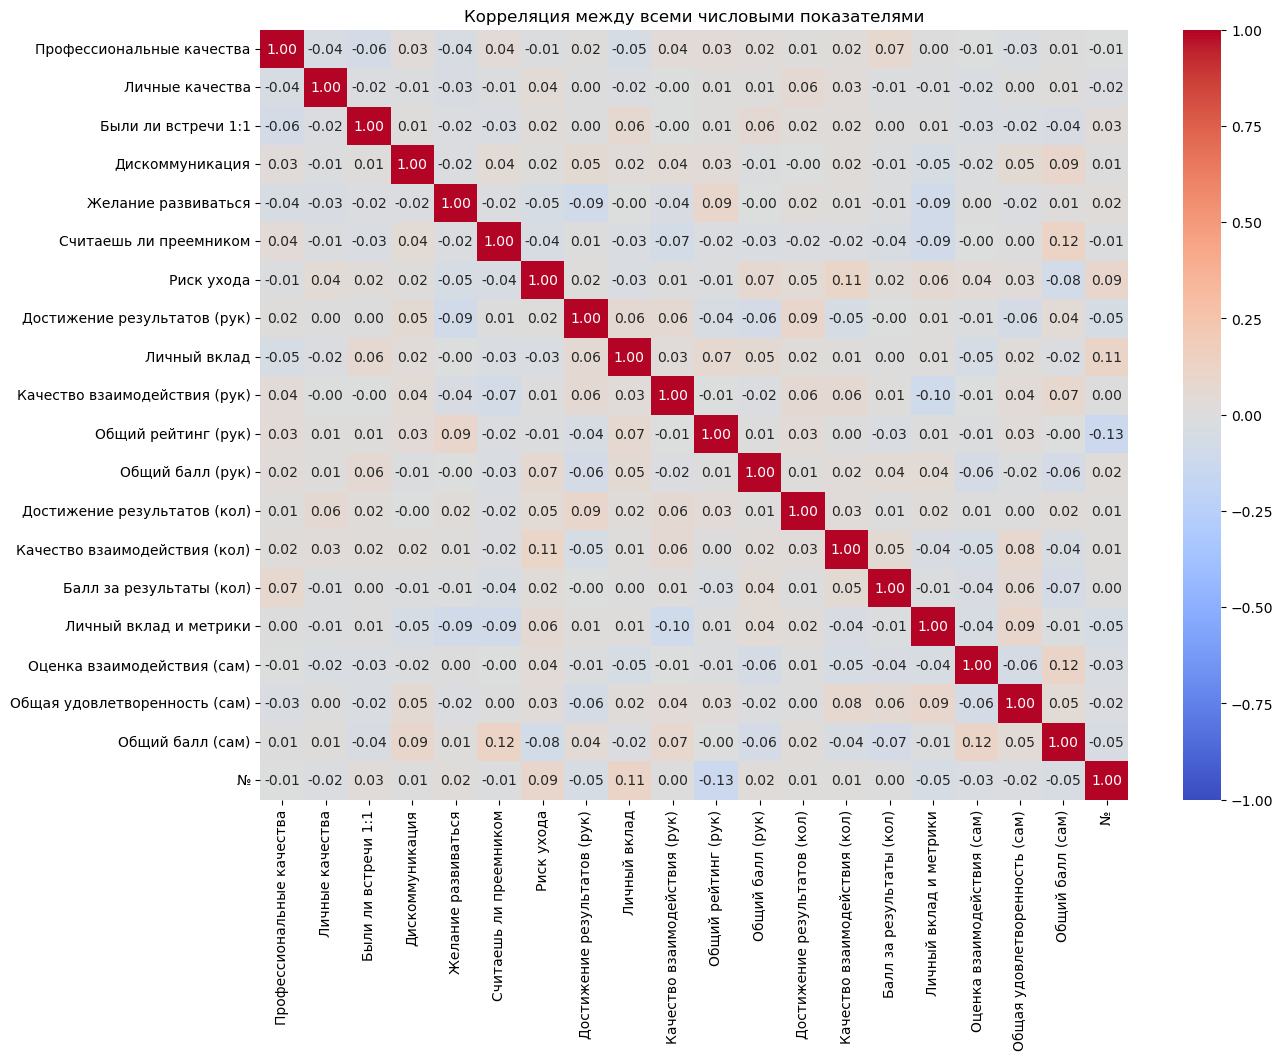

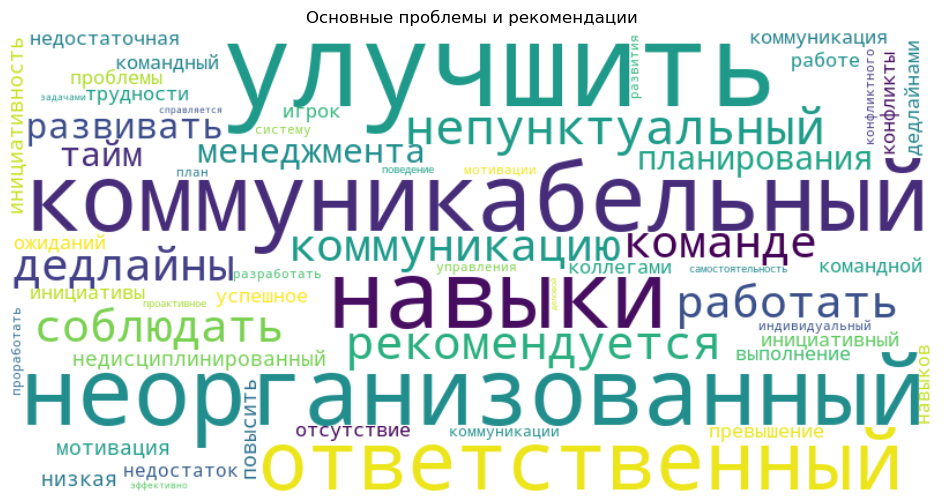

Анализ успешно выполнен


In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_results(df):
    plt.figure(figsize=(14, 10))
    
    numeric_features = df.select_dtypes(include=['int64', 'float64'])
    
    corr = numeric_features.corr()
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        cbar=True,
        vmin=-1,
        vmax=1
    )
    plt.title('Корреляция между всеми числовыми показателями')
    plt.show()
    
    def create_wordcloud(text_data):
        all_text = ' '.join(text_data)
        
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            max_words=100,
            max_font_size=100,
            collocations=False,
            stopwords=['сотрудник', 'коллега', 'результат', 'задача', 'и', 'в', 'на', 'по', 'с']
        ).generate(all_text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Основные проблемы и рекомендации')
        plt.show()
    
    text_columns = [
        'Подведение итогов',
        'Рекомендации по развитию',
        'Комментарий о личных качествах (рук)',
        'Рекомендации (рук)',
        'Комментарий о личных качествах (кол)',
        'Рекомендации (кол)'
    ]
    
    all_text_data = df[text_columns].stack().str.lower()
    create_wordcloud(all_text_data)

def perform_analysis():
    try:
        df = create_dataset()
        
        df['Сроки'] = pd.to_datetime(df['Сроки'], format='%m/2025')
        df['Фактические сроки'] = pd.to_datetime(df['Фактические сроки'], format='%m/2025')
        
        df = apply_recommendations(df)
        
        visualize_results(df)
        
        df.to_csv('employee_analysis_results.csv', index=False, encoding='utf-8-sig')
        
        print("Анализ успешно выполнен")
        
    except Exception as e:
        print(f"Произошла ошибка при выполнении анализа: {e}")

if __name__ == "__main__":
    perform_analysis()
